In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from flax import linen as nn
from jax import random

from evo_diffusion.diffusion import DDIM, cosine_beta_schedule
from evo_diffusion.model_components import SinCosEmbedding
from evo_diffusion.training import (
    create_train_state,
    create_training_batches,
    train_step_ddim,
)

In [2]:
import matplotlib.pyplot as plt # For various plots

In [3]:
class DenoiseModel(nn.Module):
    sequence_length: int
    time_embedding_dim: int = 16

    def setup(self):
        self.time_embedding = SinCosEmbedding(self.time_embedding_dim)

    @nn.compact
    def __call__(self, x, t):
        t_embedded = self.time_embedding(t)

        x = x.reshape(x.shape[0], -1)

        for feat in [128, 128, 128]:
            x = nn.Dense(feat)(x)
            x = nn.relu(x)

        x = jnp.concatenate([x, t_embedded], axis=1)

        for feat in [128, 128, 128]:
            x = nn.Dense(feat)(x)
            x = nn.relu(x)
        x = nn.Dense(self.sequence_length)(x)
        return x


# Generate synthetic data
def generate_gaussian_mixture(
    mus: list[float], sigmas: list[float], num_points_per_cluster: int
):
    noises = [
        np.random.normal(mu, sigma, size=(num_points_per_cluster, 1))
        for mu, sigma in zip(mus, sigmas)
    ]
    noises = np.concatenate((noises), axis=0)
    np.random.shuffle(noises)
    return noises

In [4]:
NUM_SAMPLES = 10_000  # Number of data points
BATCH_SIZE = 64  # Number of samples in each batch
NUM_DIFFUSION_STEPS = 20  # Number of steps for diffusion process
LEARNING_RATE = 4e-3  # Learning rate for optimizer
NUM_EPOCHS = 1000

In [5]:
# Simulate data according to 2D Gaussian mixture
np.random.seed(12)

y = generate_gaussian_mixture([-10.0, 0.0, 10.0], [1.0, 0.5, 1.0], NUM_SAMPLES)
y2 = generate_gaussian_mixture([-10.0, 0.0, 10.0], [1.0, 0.5, 1.0], NUM_SAMPLES)
y = np.concatenate((y, y2), axis=1)

Text(0, 0.5, '$x^{(2)}$')

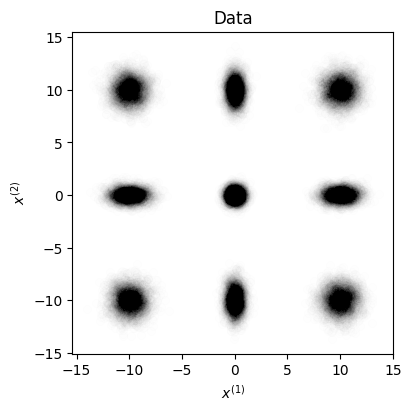

In [6]:
fig = plt.figure(figsize=(4., 4.), constrained_layout=True)
spec = fig.add_gridspec(ncols=1, nrows=1)
ax = fig.add_subplot(spec[0])
ax.scatter(y[:,0],y[:,1], color="k", alpha=0.005, label="Data")
ax.set_title("Data")
ax.set_xlabel(r"$x^{(1)}$")
ax.set_ylabel(r"$x^{(2)}$")

In [7]:
# Define denoising model and diffusion class
beta_schedule = cosine_beta_schedule(NUM_DIFFUSION_STEPS, start=0.0001, stop=0.8)
model = DenoiseModel(sequence_length=y.shape[-1])
diffusion = DDIM(model, beta_schedule=beta_schedule)

In [8]:
# Define optimizer and state
rng = random.PRNGKey(0)
rng, rng_init = random.split(rng)
state = create_train_state(rng_init, model, LEARNING_RATE, y.shape[-1])

In [9]:
# Get training data
batches = create_training_batches(y, BATCH_SIZE)

In [14]:
# Train model
train_step = jax.jit(train_step_ddim, static_argnums=0)
losses = []
for epoch in range(NUM_EPOCHS):
    rng, perm_rng, model_rng = jax.random.split(rng, 3)

    # Permute the batches
    perms = jax.random.permutation(perm_rng, len(batches))
    epoch_loss = []

    # For each batch, sample noising step and train denoising model
    model_rngs = jax.random.split(model_rng, len(perms))
    for i, perm in enumerate(perms):
        t = np.random.choice(NUM_DIFFUSION_STEPS, size=(batches[perm].shape[0], 1))
        state, loss = train_step(diffusion, state, batches[perm], t, model_rngs[i])
        epoch_loss.append(loss)
    epoch_loss = np.array(epoch_loss).mean()
    losses.append(epoch_loss)

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Train Loss: {epoch_loss:.4f}")

Epoch 0, Train Loss: 0.4808
Epoch 50, Train Loss: 0.4796
Epoch 100, Train Loss: 0.4768
Epoch 150, Train Loss: 0.4767
Epoch 200, Train Loss: 0.4767
Epoch 250, Train Loss: 0.4791
Epoch 300, Train Loss: 0.4785
Epoch 350, Train Loss: 0.4723
Epoch 400, Train Loss: 0.4787
Epoch 450, Train Loss: 0.4847
Epoch 500, Train Loss: 0.4751


KeyboardInterrupt: 

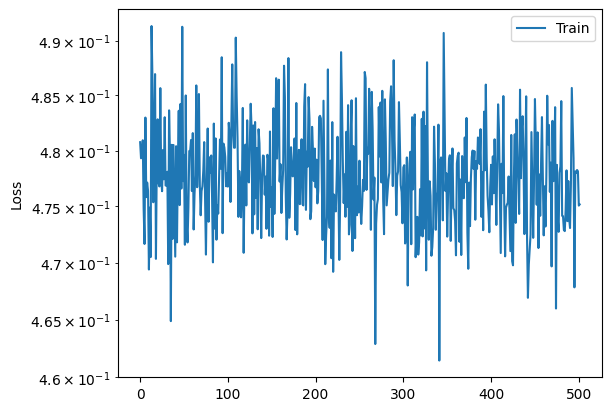

In [15]:
fig = plt.figure(figsize=(6., 4.), constrained_layout=True)
spec = fig.add_gridspec(ncols=1, nrows=1)
ax = fig.add_subplot(spec[0])
ax.plot(losses, label="Train")
ax.set_yscale("log")
ax.set_ylabel("Loss")
ax.legend()

In [16]:
# Sample from model unconditionally
samples = diffusion.reverse_process(rng, (3000, y.shape[-1]), {"params": state.params})

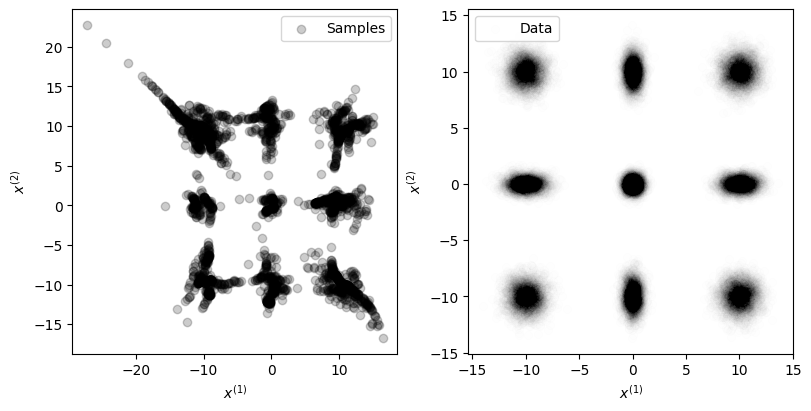

In [17]:
fig = plt.figure(figsize=(8., 4.), constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=1)
ax = fig.add_subplot(spec[0])
ax.scatter(samples[:, 0], samples[:,1], color="k", alpha=0.2, label="Samples")
ax.set_xlabel(r"$x^{(1)}$")
ax.set_ylabel(r"$x^{(2)}$")
ax.legend()

ax = fig.add_subplot(spec[1])
ax.scatter(y[:,0],y[:,1], color="k", alpha=0.005, label="Data")
ax.set_xlabel(r"$x^{(1)}$")
ax.set_ylabel(r"$x^{(2)}$")
ax.legend()

In [ ]:
# TODO: Add saving check points and loading model parameters for later 
# https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html

In [ ]:
# TODO: Add EMA on loss for clearer training